# Overall dataset stats

## stats train/val/test split

In [1]:
%%time
import matplotlib
from marss2l.utils import setup_stream_logger, get_remote_filesystem
import logging

logger = logging.getLogger(__name__)
setup_stream_logger(logger)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

C0 = "#648FFF"
C1 = "#785EF0"
C2 = "#DC267F"
C3 = "#FE6100"
C4 = "#FFB000" # #FFB000

import os

fs = get_remote_filesystem()
os.makedirs("figures", exist_ok=True)

Using account key
CPU times: user 2.07 s, sys: 1.99 s, total: 4.06 s
Wall time: 2.74 s


In [2]:
from marss2l import loaders

csv_path = "az://public/MARS-S2L/dataset_20250609/validated_images_all.csv" 

dataframe_data_traintest = loaders.read_csv(csv_path, add_columns_for_analysis=True, fs=fs, split="all", add_case_study=True,
                                            add_loc_type=True)
dataframe_data_traintest = dataframe_data_traintest[~dataframe_data_traintest.location_name.isin(loaders.LOCATIONS_CONTROL_RELEASES)].copy()
dataframe_data_traintest["country"] = dataframe_data_traintest.apply(lambda row: "Offshore" if row.offshore else row.country, 
                                                                     axis=1)
loctypedict = {
    "FiLM": "Sites seen at training time",
    "few samples": "Sites seen at training time",
    "no samples": "Test only sites"
}
# Set the type of location ("Seen at training time" or "test only")
dataframe_data_traintest["loc_type_2"] = dataframe_data_traintest["loc_type"].apply(lambda x: loctypedict[x])

rename_splits = {"test_2023": "test", "train_2023": "train", "val_2023": "val"}
dataframe_data_traintest["split_name"] = dataframe_data_traintest["split_name"].apply(lambda x: rename_splits[x] if x in rename_splits else x)

dataframe_data_traintest_test_202324= dataframe_data_traintest[dataframe_data_traintest.split_name == "test"].copy()

In [3]:
summaries = dataframe_data_traintest.groupby("split_name")["isplume"].agg(["sum", "count"]).rename(columns={"sum": "nplumes", "count": "nimages"})
summaries["nlocs"] = dataframe_data_traintest.groupby("split_name")["location_name"].nunique()
summaries_dates = dataframe_data_traintest.groupby("split_name")["tile_date"].agg(["max", "min"])
summaries["min_date"] = summaries_dates["min"].dt.strftime("%Y-%m-%d %H:%M")
summaries["max_date"] = summaries_dates["max"].dt.strftime("%Y-%m-%d %H:%M")
summaries

,nplumes,nimages,nlocs,min_date,max_date
split_name,,,,,
Not Used,395,4083,601,2013-03-19 10:08,2023-12-31 17:37
test,1813,43529,1289,2024-01-01 00:05,2024-12-31 17:27
train,3433,38366,618,2018-01-01 09:13,2023-11-30 10:33
val,288,6034,89,2021-01-01 07:03,2021-12-31 10:03


In [4]:
summaries.loc[["train","test","val"],["nplumes", "nimages"]].sum()

nplumes     5534
nimages    87929
dtype: int64

In [5]:
latex_table_summaries = summaries.loc[["train","val","test"]].rename(rename_splits).reset_index().to_latex(index=False)
print(latex_table_summaries)

\begin{tabular}{lrrrll}
\toprule
split_name & nplumes & nimages & nlocs & min_date & max_date \\
\midrule
train & 3433 & 38366 & 618 & 2018-01-01 09:13 & 2023-11-30 10:33 \\
val & 288 & 6034 & 89 & 2021-01-01 07:03 & 2021-12-31 10:03 \\
test & 1813 & 43529 & 1289 & 2024-01-01 00:05 & 2024-12-31 17:27 \\
\bottomrule
\end{tabular}



In [6]:
summaries.loc[["train","val","test"],["nplumes","nimages","nlocs"]].rename(rename_splits).reset_index().to_dict(orient="records")

[{'split_name': 'train', 'nplumes': 3433, 'nimages': 38366, 'nlocs': 618},
 {'split_name': 'val', 'nplumes': 288, 'nimages': 6034, 'nlocs': 89},
 {'split_name': 'test', 'nplumes': 1813, 'nimages': 43529, 'nlocs': 1289}]

### Stats by year

In [7]:
summaries_split_year = dataframe_data_traintest.groupby(["split_name","year"])["isplume"].agg(["sum", "count"]).rename(columns={"sum": "nplumes", "count": "nimages"})
summaries_split_year["nlocs"] = dataframe_data_traintest.groupby(["split_name","year"])["location_name"].nunique()
summaries_split_year

nplumes  nimages  nlocs
split_name year                         
Not Used   2013        5       11      2
           2014        3       13      4
           2015        4       20      4
           2016       11       41      6
           2017      157      333     14
           2021       78      120      7
           2023      137     3545    601
test       2024     1813    43529   1289
train      2018      386     5962     91
           2019      520     5993     91
           2020      509     6127     92
           2022      657     7902    216
           2023     1361    12382    616
val        2021      288     6034     89

### Stats by constellation

In [8]:
summaries_split_satellite = dataframe_data_traintest.groupby(["split_name","satellite_constellation"])["isplume"].agg(["sum", "count"]).rename(columns={"sum": "plumes", "count": "images"})
summaries_split_satellite["sites"] = dataframe_data_traintest.groupby(["split_name","satellite_constellation"])["location_name"].nunique()
summaries_split_satellite_date = dataframe_data_traintest.groupby(["split_name","satellite_constellation"])["tile_date"].agg(["max", "min"])
summaries_split_satellite["min date"] = summaries_split_satellite_date["min"].dt.strftime("%Y-%m-%d %H:%M")
summaries_split_satellite["max date"] = summaries_split_satellite_date["max"].dt.strftime("%Y-%m-%d %H:%M")
summaries_split_satellite = summaries_split_satellite[["images","plumes","sites", "min date", "max date"]]
summaries_split_satellite

images  plumes  sites          min date  \
split_name satellite_constellation                                            
Not Used   Landsat                    1476     131    532  2013-03-19 10:08   
           Sentinel-2                 2607     264    524  2016-03-30 03:25   
test       Landsat                   18247     743   1251  2024-01-01 00:05   
           Sentinel-2                25282    1070   1247  2024-01-01 03:41   
train      Landsat                    6685     913    537  2018-01-05 10:02   
           Sentinel-2                31681    2520    598  2018-01-01 09:13   
val        Landsat                     262      32     36  2021-01-04 10:08   
           Sentinel-2                 5772     256     89  2021-01-01 07:03   

                                            max date  
split_name satellite_constellation                    
Not Used   Landsat                  2023-12-31 17:15  
           Sentinel-2               2023-12-31 17:37  
test       Landsat                  2024-12-31 17:27  
           Sentinel-2               2024-12-31 17:06  
train      Landsat                  2023-11-30 07:17  
           Sentinel-2               2023-11-30 10:33  
val        Landsat                  2021-12-31 10:03  
           Sentinel-2               2021-12-31 10:03

In [9]:
summaries_split_satellite.loc[["train","val","test"],["plumes","images"]].sum()

plumes     5534
images    87929
dtype: int64

In [10]:
latex_table_summary_split_satellite = summaries_split_satellite.loc[["train","val","test"]].to_latex()
print(latex_table_summary_split_satellite)

\begin{tabular}{llrrrll}
\toprule
 &  & images & plumes & sites & min date & max date \\
split_name & satellite_constellation &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{train} & Landsat & 6685 & 913 & 537 & 2018-01-05 10:02 & 2023-11-30 07:17 \\
 & Sentinel-2 & 31681 & 2520 & 598 & 2018-01-01 09:13 & 2023-11-30 10:33 \\
\cline{1-7}
\multirow[t]{2}{*}{val} & Landsat & 262 & 32 & 36 & 2021-01-04 10:08 & 2021-12-31 10:03 \\
 & Sentinel-2 & 5772 & 256 & 89 & 2021-01-01 07:03 & 2021-12-31 10:03 \\
\cline{1-7}
\multirow[t]{2}{*}{test} & Landsat & 18247 & 743 & 1251 & 2024-01-01 00:05 & 2024-12-31 17:27 \\
 & Sentinel-2 & 25282 & 1070 & 1247 & 2024-01-01 03:41 & 2024-12-31 17:06 \\
\cline{1-7}
\bottomrule
\end{tabular}



### Stats by country all data

In [11]:
import pandas as pd
def compute_statistics(df: pd.DataFrame, group_cols: list) -> pd.DataFrame:
    """
    Compute statistics for a given DataFrame grouped by the specified columns.
    
    Parameters:
    - df: The input dataframe containing the data.
    - group_cols: A list of columns to group by (e.g., ['country']).
    
    Returns:
    - DataFrame with aggregated statistics including:
        * images: Count of images
        * plumes: Number of plumes detected
        * sites: Unique locations (sites)
        * sites_with_plumes: Unique sites with ≥1 plume
        * sites_seen_in_training: Unique sites seen during training
    
    """
    # Group by specified columns and calculate count of images and sum of plumes
    df_all = df.groupby(group_cols)["isplume"].agg(["count", "sum"]).rename({"count": "images", "sum": "plumes"}, axis=1)
    
    # Count unique locations (sites) per group (country in the example)
    nsites = df.groupby(group_cols)["location_name"].nunique()
    df_all["sites"] = nsites
    
    # Count the number of unique locations with at least one plume
    sites_with_plumes = df[df["isplume"] == 1].groupby(group_cols)["location_name"].nunique()
    df_all["sites_with_plumes"] = sites_with_plumes

    # Count unique sites seen at training time
    training_sites = (
        df[df["loc_type_2"] == "Sites seen at training time"]
        .groupby(group_cols)["location_name"]
        .nunique()
    )
    df_all["sites_seen_in_training"] = training_sites
    
    # Sort the dataframe based on the number of images
    df_all.sort_values("images", ascending=False, inplace=True)
    
    return df_all


### Stats by country: all data

In [12]:
compute_statistics(dataframe_data_traintest, ["country"])

,images,plumes,sites,sites_with_plumes,sites_seen_in_training
country,,,,,
Algeria,23819,1567,79,49.0,57.0
Turkmenistan,19276,2736,129,92.0,115.0
United States of America,11897,230,309,58.0,233.0
Libya,11408,300,283,33.0,27.0
Kazakhstan,5047,310,54,12.0,26.0
Offshore,3077,162,53,4.0,27.0
Iraq,2881,61,34,10.0,31.0
Iran (Islamic Republic of),2858,100,96,11.0,8.0
Egypt,2228,39,47,9.0,15.0


### Stats by country: test data

In [13]:
compute_statistics(dataframe_data_traintest_test_202324, ["country"])

,images,plumes,sites,sites_with_plumes,sites_seen_in_training
country,,,,,
Turkmenistan,9361,853,129,63.0,115.0
United States of America,8083,144,306,50.0,230.0
Libya,6474,121,282,25.0,26.0
Algeria,4252,296,75,27.0,53.0
Iran (Islamic Republic of),2444,70,96,9.0,8.0
Offshore,2082,39,53,3.0,27.0
Egypt,1673,24,47,8.0,15.0
Kazakhstan,1454,32,46,6.0,18.0
Uzbekistan,1159,11,30,5.0,10.0


### Stats by country: Train data

In [14]:
dataframe_data_traintest_train_202324= dataframe_data_traintest[dataframe_data_traintest.split_name == "train"].copy()
compute_statistics(dataframe_data_traintest_train_202324, ["country"])

,images,plumes,sites,sites_with_plumes,sites_seen_in_training
country,,,,,
Algeria,15974,1083,57,39.0,57
Turkmenistan,8097,1530,115,68.0,115
Libya,3873,157,27,15.0,27
Kazakhstan,3018,246,26,10.0,26
Iraq,1983,51,31,10.0,31
United States of America,1748,64,233,15.0,233
Offshore,758,95,27,4.0,27
Egypt,514,13,15,4.0,15
Iran (Islamic Republic of),330,24,8,4.0,8


### Stats by type of location

In [15]:
stats_data_by_loctype = dataframe_data_traintest_test_202324.groupby("loc_type_2")["location_name"].agg(["nunique","count"]).rename(columns={"nunique": "sites", "count": "images"})

nplumes = dataframe_data_traintest_test_202324.groupby("loc_type_2")["isplume"].sum()

stats_data_by_loctype["plumes"] = nplumes

latex_stats_data_by_loctype = stats_data_by_loctype[["images", "plumes", "sites"]].to_latex()
print(latex_stats_data_by_loctype)

\begin{tabular}{lrrr}
\toprule
 & images & plumes & sites \\
loc_type_2 &  &  &  \\
\midrule
Sites seen at training time & 27874 & 1586 & 592 \\
Test only sites & 15655 & 227 & 697 \\
\bottomrule
\end{tabular}



In [16]:
locs_training = dataframe_data_traintest_test_202324.loc[dataframe_data_traintest_test_202324["loc_type_2"] == "Sites seen at training time","location_name"].unique().tolist()
len(locs_training)

592

In [17]:
stats_data_by_loctype

,sites,images,plumes
loc_type_2,,,
Sites seen at training time,592,27874,1586
Test only sites,697,15655,227


In [18]:
# dataframe_data_traintest.columns

## Stats data case studies
### test

In [19]:
stats_test = compute_statistics(dataframe_data_traintest_test_202324, ["case_study"])
stats_test

,images,plumes,sites,sites_with_plumes,sites_seen_in_training
case_study,,,,,
Turkmenistan,9361,853,129,63,115
United States of America,8083,144,306,50,230
Libya,6474,121,282,25,26
Algeria,4252,296,75,27,53
Arabian peninsula,3594,103,90,15,31
Uzbekistan & Kazakhstan,2613,43,76,11,28
Iran (Islamic Republic of),2444,70,96,9,8
Offshore,2082,39,53,3,27
Rest,1830,8,84,7,27


In [20]:
print(stats_test[["images","plumes","sites", "sites_seen_in_training"]].to_latex())

\begin{tabular}{lrrrr}
\toprule
 & images & plumes & sites & sites_seen_in_training \\
case_study &  &  &  &  \\
\midrule
Turkmenistan & 9361 & 853 & 129 & 115 \\
United States of America & 8083 & 144 & 306 & 230 \\
Libya & 6474 & 121 & 282 & 26 \\
Algeria & 4252 & 296 & 75 & 53 \\
Arabian peninsula & 3594 & 103 & 90 & 31 \\
Uzbekistan & Kazakhstan & 2613 & 43 & 76 & 28 \\
Iran (Islamic Republic of) & 2444 & 70 & 96 & 8 \\
Offshore & 2082 & 39 & 53 & 27 \\
Rest & 1830 & 8 & 84 & 27 \\
Egypt & 1673 & 24 & 47 & 15 \\
Syrian Arab Republic & 550 & 99 & 11 & 2 \\
Iraq & 463 & 7 & 32 & 29 \\
Venezuela & 110 & 6 & 8 & 1 \\
\bottomrule
\end{tabular}



### train

In [21]:
compute_statistics(dataframe_data_traintest_train_202324, ["case_study"])

,images,plumes,sites,sites_with_plumes,sites_seen_in_training
case_study,,,,,
Algeria,15974,1083,57,39.0,57
Turkmenistan,8097,1530,115,68.0,115
Libya,3873,157,27,15.0,27
Uzbekistan & Kazakhstan,3331,255,37,13.0,37
Iraq,1983,51,31,10.0,31
United States of America,1748,64,233,15.0,233
Arabian peninsula,1163,143,31,12.0,31
Offshore,758,95,27,4.0,27
Rest,546,11,33,8.0,33


## Generate locs gpkg to plot

In [22]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

dataframe_data_traintest["loc_type_2"] = dataframe_data_traintest["loc_type"].apply(lambda x: loctypedict[x])
locations = dataframe_data_traintest.location_name.unique()
loc_df = []
for loc in locations:
    loc_info_i0 = dataframe_data_traintest[dataframe_data_traintest.location_name == loc].iloc[0].to_dict()
    loc_info_copy = {k: loc_info_i0[k] for k in ["country", "offshore", "location_name", "lon", "lat", "sector", "monitoring","case_study","loc_type_2"]}
    loc_df.append(loc_info_copy)

loc_df = pd.DataFrame(loc_df)
dataframe_data_traintest_stats = dataframe_data_traintest.groupby("location_name")["isplume"].agg(["count", "sum"]).rename(columns={"count":"nimages", "sum": "nplumes"}).reset_index()

print(loc_df.shape, dataframe_data_traintest_stats.shape)
loc_df = pd.merge(loc_df,dataframe_data_traintest_stats,on="location_name")
print(loc_df.shape)

loc_gdf = gpd.GeoDataFrame(loc_df, geometry=loc_df.apply(lambda row: Point(row.lon,row.lat), axis=1), crs="EPSG:4326")
loc_gdf

(1315, 9) (1315, 3)
(1315, 11)


,country,offshore,location_name,lon,lat,sector,monitoring,case_study,loc_type_2,nimages,nplumes,geometry
0,Libya,False,011-4K-001_1,17.368569,28.949074,Oil and Gas,True,Libya,Test only sites,20,0,POINT (17.36857 28.94907)
1,Libya,False,011-4K-001_2,17.352176,28.922220,Oil and Gas,True,Libya,Test only sites,11,0,POINT (17.35218 28.92222)
2,Libya,False,011-4K-001_3,17.337649,28.957567,Oil and Gas,True,Libya,Test only sites,10,0,POINT (17.33765 28.95757)
3,Libya,False,011-4K-001_4,17.379427,28.930596,Oil and Gas,True,Libya,Test only sites,28,0,POINT (17.37943 28.9306)
4,Libya,False,011-4K-001_5,17.376165,28.902122,Oil and Gas,True,Libya,Test only sites,13,0,POINT (17.37617 28.90212)
...,...,...,...,...,...,...,...,...,...,...,...,...
1310,United States of America,False,q,-103.483165,31.377683,Oil and Gas,False,United States of America,Sites seen at training time,30,0,POINT (-103.48316 31.37768)
1311,United States of America,False,t,-103.628188,31.974831,Oil and Gas,False,United States of America,Sites seen at training time,37,0,POINT (-103.62819 31.97483)
1312,United States of America,False,v,-103.561737,31.688356,Oil and Gas,True,United States of America,Sites seen at training time,162,0,POINT (-103.56174 31.68836)
1313,United States of America,False,w,-103.937501,31.643654,Oil and Gas,True,United States of America,Sites seen at training time,81,0,POINT (-103.9375 31.64365)


In [23]:
from matplotlib import colors
from shapely.geometry import box
from marss2l.mars_sentinel2 import countries
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

try:
    loc_gdf.explore(column="loc_type_2",cmap=colors.ListedColormap(["C0","C1","C2"]))
except Exception as e:
    print(e)

The 'folium', 'matplotlib' and 'mapclassify' packages are required for 'explore()'. You can install them using 'conda install -c conda-forge folium matplotlib mapclassify' or 'pip install folium matplotlib mapclassify'.


In [24]:
loc_gdf.to_file("all_locs.gpkg", driver="GPKG",index=False)

## Derive shapes of boundaries for the case studies

In [25]:
# Create the grouped dataframe


case_studies_df = loc_gdf.groupby("case_study")[["lat", "lon"]].agg(["min","max"])

# Flatten the multi-level column names
case_studies_df.columns = [f"{col[0]}_{col[1]}" for col in case_studies_df.columns]
case_studies_df.reset_index()
case_studies_df["geometry"] = case_studies_df.apply(lambda x: box(x.lon_min,x.lat_min, x.lon_max, x.lat_max), axis=1)
case_studies_df =gpd.GeoDataFrame(case_studies_df, crs="EPSG:4326")
case_studies_not_index = case_studies_df.reset_index()
case_studies_df

,lat_min,lat_max,lon_min,lon_max,geometry
case_study,,,,,
Algeria,27.423070,33.121177,2.848560,9.920190,"POLYGON ((9.92019 27.42307, 9.92019 33.12118, ..."
Arabian peninsula,15.563700,31.722848,40.079818,56.701641,"POLYGON ((56.70164 15.5637, 56.70164 31.72285,..."
Egypt,27.233037,31.076103,25.921466,33.768051,"POLYGON ((33.76805 27.23304, 33.76805 31.0761,..."
Iran (Islamic Republic of),26.499511,38.517800,45.357340,60.867590,"POLYGON ((60.86759 26.49951, 60.86759 38.5178,..."
Iraq,30.167830,36.308255,42.575067,47.743480,"POLYGON ((47.74348 30.16783, 47.74348 36.30826..."
Libya,26.051989,31.800808,9.847870,22.794313,"POLYGON ((22.79431 26.05199, 22.79431 31.80081..."
Offshore,-13.785400,46.438223,-92.296200,123.316000,"POLYGON ((123.316 -13.7854, 123.316 46.43822, ..."
Rest,-50.746178,52.296280,-113.967553,151.418900,"POLYGON ((151.4189 -50.74618, 151.4189 52.2962..."
Syrian Arab Republic,34.681681,35.374983,38.396022,41.138898,"POLYGON ((41.1389 34.68168, 41.1389 35.37498, ..."


<Axes: >

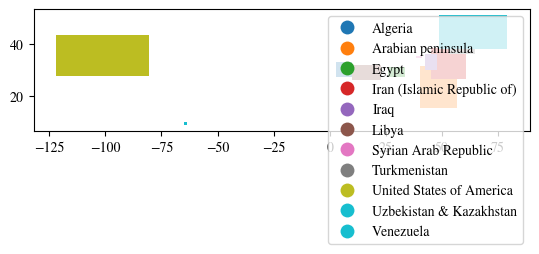

In [26]:
case_studies_not_index[~case_studies_not_index.case_study.isin(["Rest","Offshore"])].plot("case_study", legend=True)

In [27]:
case_studies_not_index.to_file("case_study_boundaries.gpkg", driver="GPKG",index=False)

/home/gonzalo/mambaforge/envs/marss2ltacopy312/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(


<Axes: >

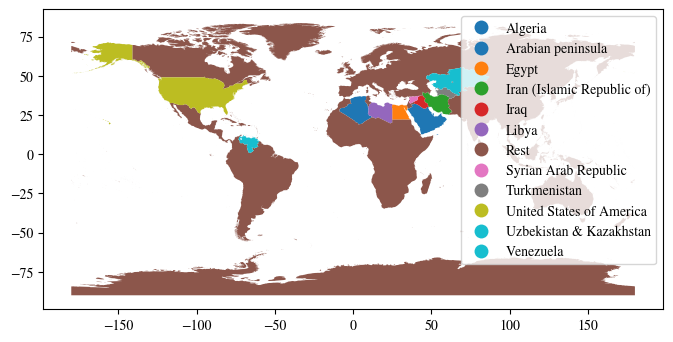

In [28]:
countries_df = countries.all_countries()
countries_df["case_study"] = countries_df.romnam.apply(loaders._set_case_study)
case_studies_df_boundaries = countries_df[["case_study","geometry"]].dissolve(by="case_study").reset_index()
case_studies_df_boundaries

fig, ax = plt.subplots(1, 1, figsize=(8,10))
case_studies_df_boundaries.plot("case_study", legend=True, ax=ax)

<Axes: >

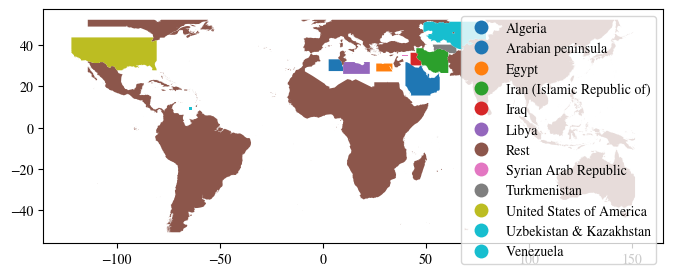

In [29]:
new_geometry = case_studies_df_boundaries.set_index("case_study")["geometry"].intersection(case_studies_df.geometry, align=True)
new_geometry = new_geometry[new_geometry.index != "Offshore"]
case_studies_df_boundaries_intersect = gpd.GeoDataFrame(geometry=new_geometry, crs="EPSG:4326").reset_index()
fig, ax = plt.subplots(1, 1, figsize=(8,10))
case_studies_df_boundaries_intersect.plot("case_study", legend=True, ax=ax)

## Basemap plots

Text(0.5, 1.0, 'MARS-S2L dataset')

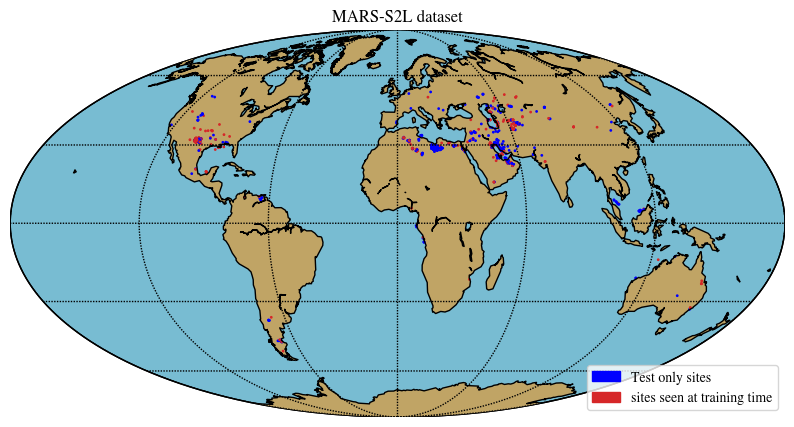

In [30]:
from mpl_toolkits.basemap import Basemap
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1,1, figsize=(10,6))
ocean_color = (plt.get_cmap('ocean'))(210)
land_color = plt.get_cmap('gist_earth')(200)
# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='moll',lon_0=0,resolution='c',ax=ax)

m.drawcoastlines()
m.fillcontinents(color=land_color,lake_color=ocean_color)
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))
m.drawmapboundary(fill_color=ocean_color) 

x, y = m(loc_gdf.lon,loc_gdf.lat)
colors_scatter = loc_gdf.loc_type_2.apply(lambda x: "blue" if x == "Test only sites" else "C3")
m.scatter(x,y,1,marker='o',color=colors_scatter)

patches = []
for c, interp in zip(["blue", "C3"], ["Test only sites", "sites seen at training time"]):
    patches.append(mpatches.Patch(color=c, label=interp))

ax.legend(handles=patches,
          loc='lower right')

ax.set_title("MARS-S2L dataset")

In [31]:
stats_sites = stats_data_by_loctype.to_dict()["sites"]

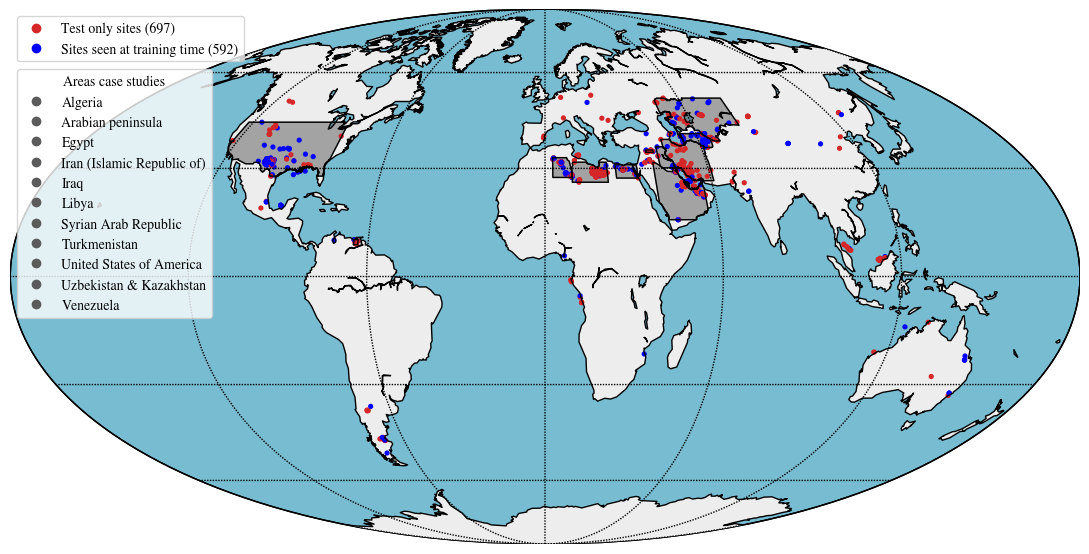

In [37]:
from mpl_toolkits.basemap import Basemap
from matplotlib.lines import Line2D

# First, calculate the overall bounds with some padding


def plot_dataset_locs(projection="merc", min_lon=None, max_lon=None, min_lat=None, 
                      max_lat=None, title="MARS-S2L",colors=None,
                      legend_case_studies=True,
                      figsize=(11,6)):
    if min_lon is None:
        min_lon = case_studies_not_index.loc[~case_studies_not_index.case_study.isin(["Rest", "Offshore"]),'lon_min'].min() - 2  # Add 5 degrees padding
    if max_lon is None:
        max_lon = case_studies_not_index.loc[~case_studies_not_index.case_study.isin(["Rest", "Offshore"]),'lon_max'].max() + 2
    if min_lat is None:
        min_lat = case_studies_not_index.loc[~case_studies_not_index.case_study.isin(["Rest", "Offshore"]),'lat_min'].min() - 5
    if max_lat is None:
        max_lat = case_studies_not_index.loc[~case_studies_not_index.case_study.isin(["Rest", "Offshore"]),'lat_max'].max() + 2
    
    fig, ax = plt.subplots(1,1, figsize=figsize, tight_layout=True)
    ocean_color = (plt.get_cmap('ocean'))(210)
    land_color = plt.get_cmap('gist_earth')(200)
    land_color = "#ededed"
    # lon_0 is central longitude of projection.
    
    m = Basemap(projection=projection,lon_0=0,
                llcrnrlon=min_lon, llcrnrlat=min_lat,
                urcrnrlon=max_lon, urcrnrlat=max_lat,
                resolution='c', ax=ax) 
    
    m.drawcoastlines()
    m.fillcontinents(color=land_color,lake_color=ocean_color)
    # draw parallels and meridians.
    m.drawparallels(np.arange(-90.,120.,30.))
    m.drawmeridians(np.arange(0.,420.,60.))
    m.drawmapboundary(fill_color=ocean_color) 
    
    # Create a colormap for different case studies
    just_one_color=False
    legend_patches = []
    if colors is None:
        colors = plt.cm.tab20(np.linspace(0, 1, len(case_studies_df)))
    elif isinstance(colors,str):
        # case_studies = [c for c in case_studies_df_boundaries_intersect.case_study.unique().tolist() if c not in ["Rest", "Offshore"]]
        # case_studies_txt = "\n".join(case_studies)
        colors = [colors for _ in range(len(case_studies_df))]
        # legend_patches = [mpatches.Patch(color=colors[0], label="Areas case studies:\n"+case_studies_txt)]

    area_plot = box(min_lon,min_lat, max_lon, max_lat)
    
    # Loop through each case study in the results DataFrame
    for i, (idx, row) in enumerate(case_studies_df_boundaries_intersect.iterrows()):
        case_name = row.case_study 
        if case_name in ["Rest", "Offshore"]:
            continue
    
        geom = row.geometry

        if not geom.intersects(area_plot):
            continue
    
        color = colors[i]
        
        if geom.geom_type == 'Polygon':
            # Extract and transform coordinates
            x, y = geom.exterior.xy
            map_x, map_y = m(x, y)
            # Plot polygon outline and fill
            m.plot(map_x, map_y, 'k-', linewidth=1)
            ax.fill(map_x, map_y, alpha=0.5, color=color)
            
        elif geom.geom_type == 'MultiPolygon':
            # Handle each polygon in the multipolygon
            for polygon in geom.geoms:
                x, y = polygon.exterior.xy
                map_x, map_y = m(x, y)
                m.plot(map_x, map_y, 'k-', linewidth=1)
                ax.fill(map_x, map_y, alpha=0.5, color=color)
        
        # Create a patch for the legend
        # legend_patches.append(mpatches.Patch(color=color, label=case_name))
        legend_patches.append(Line2D([0], [0], marker='o', color=color, linestyle='None',
                label=case_name))
    
    # Scatterplot of sites
    x, y = m(loc_gdf.lon,loc_gdf.lat)
    colors_scatter = loc_gdf.loc_type_2.apply(lambda x: "C3" if x == "Test only sites" else "blue")
    m.scatter(x,y,7.5,marker='o',color=colors_scatter)

    stats_sites = stats_data_by_loctype.to_dict()["sites"]
    
    patches = []
    for c, interp in zip(["C3", "blue"], ["Test only sites", "Sites seen at training time"]):
         patches.append(Line2D([0], [0], marker='o', color=c, linestyle='None',
                label=f"{interp} ({stats_sites[interp]})"))
        
        # patches.append(mpatches.Patch(color=c, label=f"{interp} ({stats_sites[interp]})"))
    
    legend1 = ax.legend(handles=patches,
              loc='upper left')
    
    # Add a legend outside the plot
    if legend_case_studies:
        ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0,0.9), title="Areas case studies")
    
    ax.add_artist(legend1)
    
    ax.set_title(title)
    fig.tight_layout()
    return fig, ax
    
plot_dataset_locs(projection="moll", colors="#5b5b5b", title="")
plt.savefig("figures/fig1_map_with_case_studies.pdf")

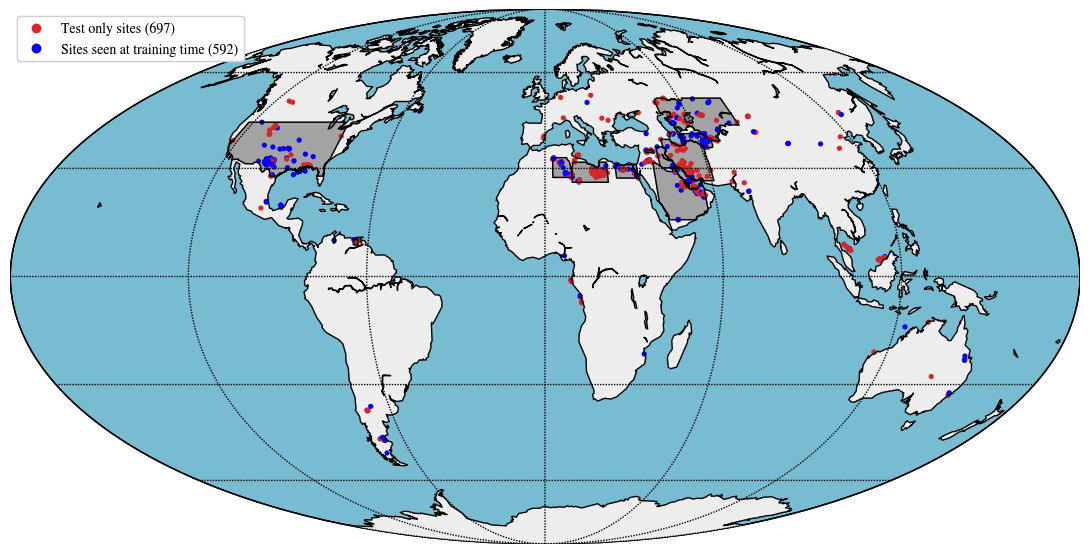

In [38]:
plot_dataset_locs(projection="moll", colors="#5b5b5b", title="", legend_case_studies=False)
plt.savefig("figures/fig1_map_with_case_studies_no_casestudieslegend.pdf")

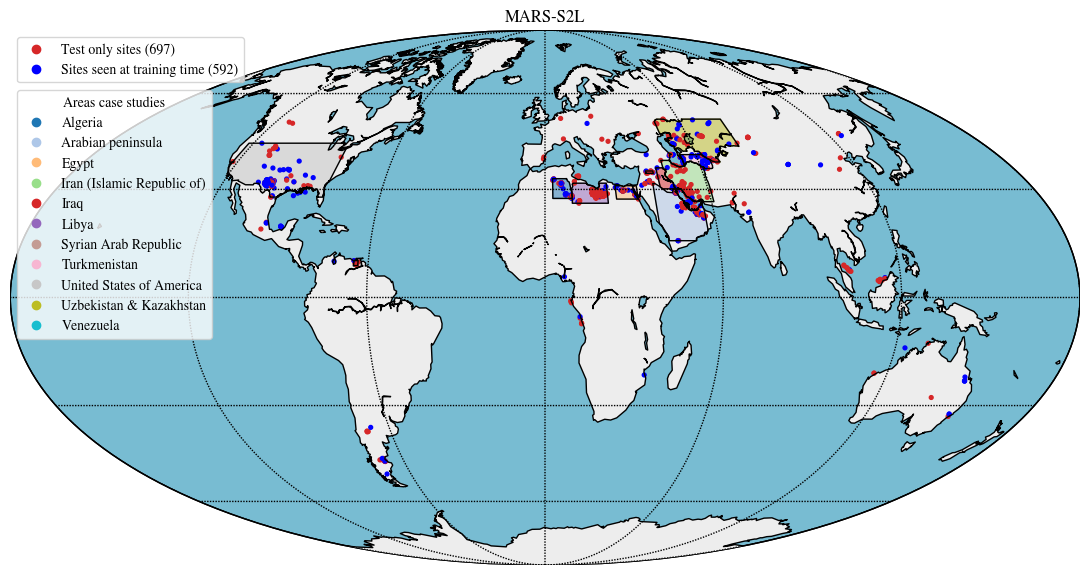

In [39]:
plot_dataset_locs(projection="moll")
plt.savefig("figures/fig1_map_with_case_studies_colors.pdf")

(<Figure size 1100x600 with 1 Axes>, <Axes: title={'center': 'MARS-S2L'}>)

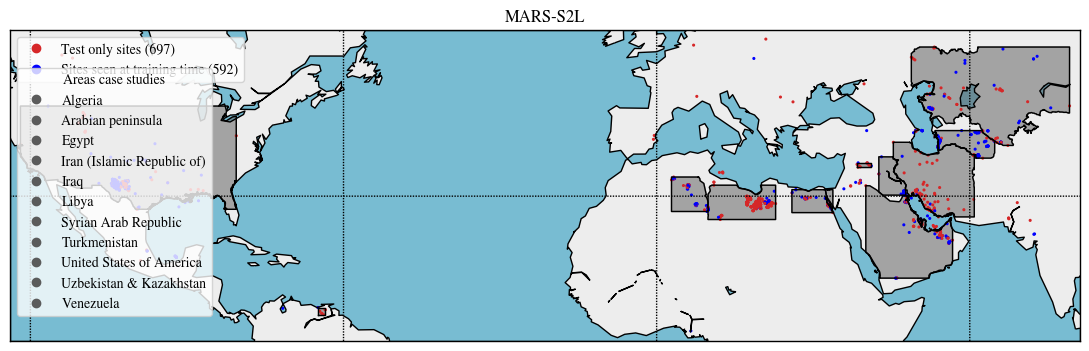

In [34]:
plot_dataset_locs(colors="#5b5b5b")

(<Figure size 1100x600 with 1 Axes>, <Axes: title={'center': 'MARS-S2L'}>)

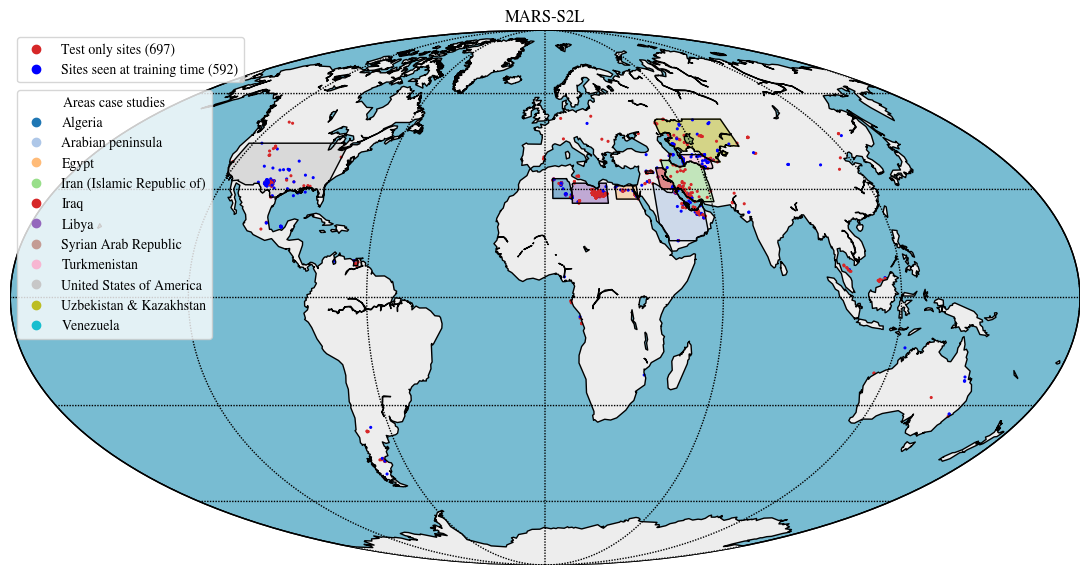

In [35]:
plot_dataset_locs(projection="moll")

(<Figure size 1100x600 with 1 Axes>, <Axes: title={'center': 'Permian'}>)

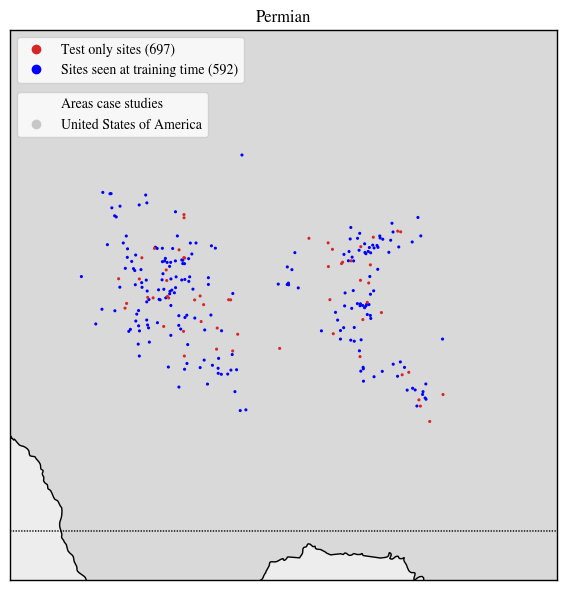

In [36]:
# BBox Permian basin. 
max_lat, min_lon = 34.058354, -105.175890
min_lat, max_lon = 29.593088, -99.939494
plot_dataset_locs(min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat, title="Permian")

(<Figure size 1100x600 with 1 Axes>, <Axes: title={'center': 'Persian Gulf'}>)

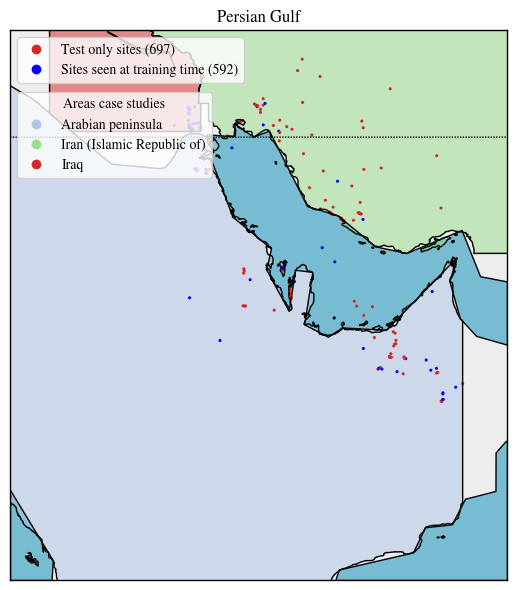

In [37]:
# BBox Persian Gulf 
, 
max_lat, min_lon = 26.11167903485588 + 7, 51.22215743823728 - 10
min_lat, max_lon = 26.11167903485588 - 10, 51.22215743823728 + 7
plot_dataset_locs(min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat, title="Persian Gulf")

(<Figure size 1100x600 with 1 Axes>, <Axes: title={'center': 'Persian Gulf'}>)

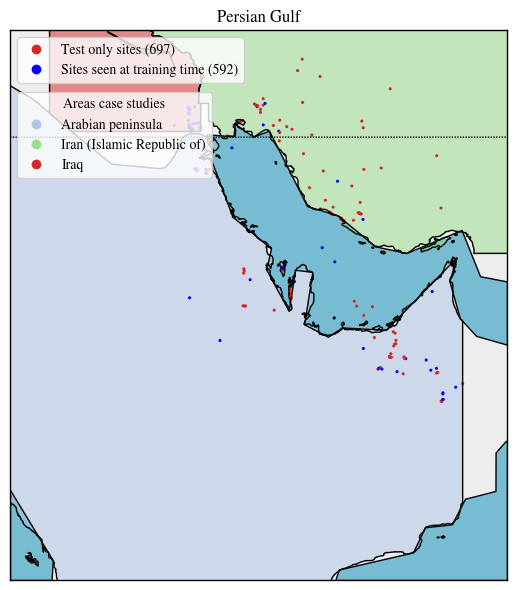

In [38]:

max_lat, min_lon = 26.11167903485588 + 7, 51.22215743823728 - 10
min_lat, max_lon = 26.11167903485588 - 10, 51.22215743823728 + 7
plot_dataset_locs(min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat, title="Persian Gulf")